## Transform ResStock Run Results to 15 SF prototypes (Elevate Energy)

In [1]:
import pandas as pd
import numpy as np
import os
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/OpenStudio-BuildStock/files


### Download results from S3:
://S3/resbldg-datasets/chicagoeui

In [58]:
# local path to downloaded results
iteration = '_10' # <----- options: 'base', '_01'~'_10', '_national_2018'
result_path = '/Users/lliu2/Documents/Chicago retrofits/ResStock results/'
iteration_path = f'cookcnty_2007{iteration}/baseline' 
baseline_result = os.path.join(result_path,iteration_path,'results_up00.parquet')
print(f'Result and file storage path: {iteration_path}')


Result and file storage path: cookcnty_2007_10/baseline


In [59]:
res = pd.read_parquet(baseline_result)
res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,9,2020-11-30 13:51:24,2020-11-30 13:52:52,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,5.211619,2.928751,2.014916,1.794072,16.181818,18.000000,9.645760,5.996591,5346.0,10.806813
1,2,13,2020-11-30 13:02:11,2020-11-30 13:04:38,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,18.341147,8.385991,6.456790,5.179484,15.454545,16.363636,39.067119,23.374391,5608.0,46.008231
2,3,17,2020-11-30 12:43:50,2020-11-30 12:45:23,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,10.698449,2.516526,2.167809,1.526475,15.636364,18.090909,21.632083,13.009301,5752.0,27.563644
3,4,3,2020-11-30 14:34:48,2020-11-30 14:41:10,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,40.299300,9.415054,16.211611,9.615784,13.727273,13.454545,73.767547,91.394255,2083.0,118.434806
4,5,5,2020-11-30 13:44:27,2020-11-30 13:45:54,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,4.862120,1.494523,1.805279,1.204725,18.000000,17.727273,13.389142,6.365466,5250.0,15.911895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,13,2020-11-30 16:09:43,2020-11-30 16:11:14,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.746049,1.385663,1.320767,1.281302,13.818182,16.363636,32.075799,10.064034,4528.0,35.448013
39996,39997,7,2020-11-30 14:39:55,2020-11-30 14:41:23,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,6.786417,1.618613,1.309069,1.326958,15.272727,17.909091,19.444267,6.811361,4527.0,24.472204
39997,39998,14,2020-11-30 15:14:27,2020-11-30 15:49:03,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,232.634375,84.974626,36.295144,50.914634,14.818182,16.090909,467.184452,377.840403,6020.0,658.864103
39998,39999,33,2020-11-30 15:10:34,2020-11-30 15:12:25,Success,NaN,NaN,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,29.113201,11.319081,2.961882,3.299177,15.545455,16.909091,78.488617,17.152437,5080.0,84.206938


In [60]:
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res

In [61]:
### HVAC cols changed after HVAC restructuring (implemented in Run5)
if iteration in ['base','_01','_02','_04']:
    cooling_col = 'build_existing_model.hvac_system_cooling_type'
else:
    cooling_col = 'build_existing_model.hvac_cooling_type'
if iteration in ['base','_01','_02','_04']:
    heating_col = 'build_existing_model.hvac_system_heating_natural_gas'
else:
    heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')


selected


### Check housing charateristics distributions

In [62]:
proto_chars = ['build_existing_model.geometry_stories',
              'build_existing_model.geometry_wall_type',
              'build_existing_model.vintage_acs',
              cooling_col,
              heating_col,
              'build_existing_model.geometry_floor_area'
             ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iteration_path} - RESULT SUMMARY:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, iteration_path, 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, iteration_path)}')

>>> ResStock - cookcnty_2007_10/baseline - RESULT SUMMARY:

  * 39829 / 40000 samples ran successfully, 171 failed, efficacy: 99.6% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_stories
1             0.506164
2             0.283110
3             0.210726
N_failed    171.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_wall_type
Masonry       0.700168
WoodStud      0.299832
N_failed    171.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.vintage_acs
1940-59       0.234327
1960-79       0.255015
1980-99       0.137412
2000-09       0.076351
2010s         0.011725
<1940         0.285169
N_failed    171.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.hvac_cooling_type
Central AC      0.616335
Heat Pump       0.025710
None            0.052198
Room AC         0.305757
N_failed      171.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_heating_type_and_fuel
Elec

### Add additional metrics to ResStock results

In [63]:
# (1) add sqft and eui
sqft_map = {'0-499': 328,
            '500-749': 633,
            '750-999': 885,
            '1000-1499': 1220,
            '1500-1999': 1690,
            '2000-2499': 2176,
            '2500-2999': 2663,
            '3000-3999': 3301,
            '4000+': 8194}

res['sqft'] = res['build_existing_model.geometry_floor_area'].map(sqft_map)
res['gas_eui'] = res['simulation_output_report.total_site_natural_gas_therm'].divide(res['sqft'])
res['elec_eui'] = res['simulation_output_report.total_site_electricity_kwh'].divide(res['sqft'])


# (2) aggregate heating and cooling end uses in ResStock results
res['total_gas_heating'] = res['simulation_output_report.natural_gas_central_system_heating_therm'] +\
    res['simulation_output_report.natural_gas_heating_therm']

res['total_elec_heating'] = res['simulation_output_report.electricity_central_system_heating_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_heating_kwh'] +\
    res['simulation_output_report.electricity_fans_heating_kwh'] +\
    res['simulation_output_report.electricity_heating_kwh'] +\
    res['simulation_output_report.electricity_pumps_heating_kwh']

res['total_elec_cooling'] = res['simulation_output_report.electricity_central_system_cooling_kwh'] +\
    res['simulation_output_report.electricity_central_system_pumps_cooling_kwh'] +\
    res['simulation_output_report.electricity_cooling_kwh'] +\
    res['simulation_output_report.electricity_fans_cooling_kwh'] +\
    res['simulation_output_report.electricity_pumps_cooling_kwh']

## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')

new cols added to "res"


In [64]:
### get sqft distr by building type and vintage
res_sqft_distr = res.groupby(['build_existing_model.geometry_building_type_recs', 'build_existing_model.vintage_acs',
    'build_existing_model.geometry_floor_area'])['building_id'].count().to_frame()

# normalize
res_sqft_distr = res_sqft_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)

# export
res_sqft_distr.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_floor_area.csv'), index=True)
print('sqft distr by vintage & bldg type exported')


sqft distr by vintage & bldg type exported


In [65]:
### get foundation type distr by building type, vintage

res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['build_existing_model.vintage_acs', 'build_existing_model.geometry_stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)
res_found_distr



build_existing_model.geometry_foundation_type                              Crawl  \
build_existing_model.vintage_acs build_existing_model.geometry_stories             
1940-59                          1                                      0.125570   
                                 2                                      0.141421   
                                 3                                      0.108696   
1960-79                          1                                      0.161756   
                                 2                                      0.158187   
                                 3                                      0.119403   
1980-99                          1                                      0.190797   
                                 2                                      0.213026   
                                 3                                      0.115385   
2000-09                          1                                      0.113846   
                                 2                                      0.090244   
                                 3                                      0.111111   
2010s                            1                                      0.139535   
                                 2                                      0.079365   
                                 3                                           NaN   
<1940                            1                                      0.158042   
                                 2                                      0.169545   
                                 3                                      0.158273   

build_existing_model.geometry_foundation_type                           Heated Basement  \
build_existing_model.vintage_acs build_existing_model.geometry_stories                    
1940-59                          1                                             0.427985   
                                 2                                             0.402815   
                                 3                                             0.369565   
1960-79                          1                                             0.350522   
                                 2                                             0.382979   
                                 3                                             0.582090   
1980-99                          1                                             0.310887   
                                 2                                             0.331072   
                                 3                                             0.346154   
2000-09                          1                                             0.584615   
                                 2                                             0.548780   
                                 3                                             0.333333   
2010s                            1                                             0.604651   
                                 2                                             0.523810   
                                 3                                                  NaN   
<1940                            1                                             0.283916   
                                 2                                             0.270909   
                                 3                                             0.338129   

build_existing_model.geometry_foundation_type                           Pier and Beam  \
build_existing_model.vintage_acs build_existing_model.geometry_stories                  
1940-59                          1                                           0.014357   
                                 2                                           0.012064   
                                 3                                                NaN   
1960-79                          1                   

In [35]:
### get foundation type distr by building type, vintage (EE prototype)

res_found_distr = res[res['build_existing_model.geometry_building_type_recs'] =="Single-Family Detached"].groupby(
    ['vintage_ee', 'stories',
    'build_existing_model.geometry_foundation_type'])['building_id'].count().to_frame()

# normalize
res_found_distr = res_found_distr.groupby(level = [0,1])['building_id'].apply(lambda x: x/x.sum()).unstack(level=2)
res_found_distr


build_existing_model.geometry_foundation_type     Crawl  Heated Basement  \
vintage_ee   stories                                                       
1: pre-1942  1: <2 stories                     0.169772         0.265010   
             2: 2+ stories                     0.162100         0.271689   
2: 1942-1978 1: <2 stories                     0.146730         0.367145   
             2: 2+ stories                     0.170830         0.343272   
3: post-1978 1: <2 stories                     0.154734         0.352579   
             2: 2+ stories                     0.138007         0.367528   

build_existing_model.geometry_foundation_type  Pier and Beam      Slab  \
vintage_ee   stories                                                     
1: pre-1942  1: <2 stories                          0.004141  0.053830   
             2: 2+ stories                          0.012557  0.067352   
2: 1942-1978 1: <2 stories                          0.020734  0.206699   
             2: 2+ stories                          0.021757  0.214343   
3: post-1978 1: <2 stories                          0.013857  0.231717   
             2: 2+ stories                          0.017712  0.261993   

build_existing_model.geometry_foundation_type  Unheated Basement  
vintage_ee   stories                                              
1: pre-1942  1: <2 stories                              0.507246  
             2: 2+ stories                              0.486301  
2: 1942-1978 1: <2 stories                              0.258692  
             2: 2+ stories                              0.249799  
3: post-1978 1: <2 stories                              0.247113  
             2: 2+ stories                              0.214760

In [36]:
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_floor_area_bin','build_existing_model.geometry_wall_type',
'build_existing_model.vintage_acs'])['building_id'].count()

build_existing_model.geometry_floor_area_bin  build_existing_model.geometry_wall_type  build_existing_model.vintage_acs
0-1499                                        Masonry                                  1940-59                             283
                                                                                       1960-79                             178
                                                                                       1980-99                              73
                                                                                       2000-09                              26
                                                                                       2010s                                 7
                                                                                       <1940                               158
                                              WoodStud                                 1940-59                        

In [37]:
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_wall_type','stories',
'build_existing_model.vintage'])['gas_eui'].mean().unstack(level=-1)

build_existing_model.vintage                              1940s     1950s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.684101  0.690659   
                                        2: 2+ stories  0.771525  0.807702   
WoodStud                                1: <2 stories  0.761761  0.778996   
                                        2: 2+ stories  0.852331  0.898863   

build_existing_model.vintage                              1960s     1970s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.622227  0.557976   
                                        2: 2+ stories  0.716290  0.615688   
WoodStud                                1: <2 stories  0.671872  0.558558   
                                        2: 2+ stories  0.811908  0.621496   

build_existing_model.vintage                              1980s     1990s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.456554  0.371588   
                                        2: 2+ stories  0.437891  0.372117   
WoodStud                                1: <2 stories  0.426862  0.378791   
                                        2: 2+ stories  0.468157  0.385075   

build_existing_model.vintage                              2000s     2010s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.295283  0.305492   
                                        2: 2+ stories  0.298608  0.294071   
WoodStud                                1: <2 stories  0.316522  0.271593   
                                        2: 2+ stories  0.310635  0.285653   

build_existing_model.vintage                              <1940  
build_existing_model.geometry_wall_type stories                  
Masonry                                 1: <2 stories  0.748823  
                                        2: 2+ stories  0.744136  
WoodStud                                1: <2 stories  0.849221  
                                        2: 2+ stories  0.863646

In [38]:
res[res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached"].groupby([
    'build_existing_model.geometry_wall_type','stories',
'build_existing_model.vintage'])['gas_eui'].mean().unstack(level=-1)

build_existing_model.vintage                              1940s     1950s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.684101  0.690659   
                                        2: 2+ stories  0.771525  0.807702   
WoodStud                                1: <2 stories  0.761761  0.778996   
                                        2: 2+ stories  0.852331  0.898863   

build_existing_model.vintage                              1960s     1970s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.622227  0.557976   
                                        2: 2+ stories  0.716290  0.615688   
WoodStud                                1: <2 stories  0.671872  0.558558   
                                        2: 2+ stories  0.811908  0.621496   

build_existing_model.vintage                              1980s     1990s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.456554  0.371588   
                                        2: 2+ stories  0.437891  0.372117   
WoodStud                                1: <2 stories  0.426862  0.378791   
                                        2: 2+ stories  0.468157  0.385075   

build_existing_model.vintage                              2000s     2010s  \
build_existing_model.geometry_wall_type stories                             
Masonry                                 1: <2 stories  0.295283  0.305492   
                                        2: 2+ stories  0.298608  0.294071   
WoodStud                                1: <2 stories  0.316522  0.271593   
                                        2: 2+ stories  0.310635  0.285653   

build_existing_model.vintage                              <1940  
build_existing_model.geometry_wall_type stories                  
Masonry                                 1: <2 stories  0.748823  
                                        2: 2+ stories  0.744136  
WoodStud                                1: <2 stories  0.849221  
                                        2: 2+ stories  0.863646

In [39]:
res_by_foundation = res[(res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")].groupby([
    'vintage_ee', 'stories', 'build_existing_model.geometry_wall_type',
    'build_existing_model.geometry_foundation_type'
])
res_by_foundation1 = res_by_foundation['gas_eui'].mean().unstack(level=0)
res_by_foundation2 = res_by_foundation[
    'simulation_output_report.total_site_natural_gas_therm'].mean().unstack(level=0)
res_by_foundation3 = res_by_foundation['building_id'].count().unstack(level=0)
res_by_foundation4 = res_by_foundation['sqft'].mean().unstack(level=0)

res_by_foundation1['type'] = 'gas eui'
res_by_foundation2['type'] = 'gas'
res_by_foundation3['type'] = 'count'
res_by_foundation4['type'] = 'sqft'

res_by_foundation_all = pd.concat([res_by_foundation1,res_by_foundation2,res_by_foundation3, res_by_foundation4], axis=0)
#res_by_foundation_all.to_csv(os.path.join(result_path, iteration_path, 'building_type_vintage_foundation.csv'), index=True)
print('foundation type eui, sqft, count distr by vintage & bldg type exported')

res_by_foundation_all.head(10*4)

foundation type eui, sqft, count distr by vintage & bldg type exported


vintage_ee                                                                                           1: pre-1942  \
stories       build_existing_model.geometry_wall_type build_existing_model.geometry_foundation_type                
1: <2 stories Masonry                                 Crawl                                             0.879584   
                                                      Heated Basement                                   0.495086   
                                                      Pier and Beam                                          NaN   
                                                      Slab                                              0.743760   
                                                      Unheated Basement                                 0.811858   
              WoodStud                                Crawl                                             1.084113   
                                                      Heated Basement                                   0.591067   
                                                      Pier and Beam                                     1.221598   
                                                      Slab                                              0.639998   
                                                      Unheated Basement                                 0.941857   
2: 2+ stories Masonry                                 Crawl                                             0.839856   
                                                      Heated Basement                                   0.627134   
                                                      Pier and Beam                                     1.069716   
                                                      Slab                                              0.731390   
                                                      Unheated Basement                                 0.782666   
              WoodStud                                Crawl                                             0.970067   
                                                      Heated Basement                                   0.695328   
                                                      Pier and Beam                                     0.973800   
                                                      Slab                                              0.939912   
                                                      Unheated Basement                                 0.903136   
1: <2 stories Masonry                                 Crawl                                          1177.700979   
                                                      Heated Basement                                 728.174054   
                                                      Pier and Beam                                          NaN   
                                                      Slab                                            972.086377   
                                                      Unheated Basement                              1093.353424   
              WoodStud                                Crawl                                          1386.061421   
                                                      Heated Basement                                 765.849155   
                                                      Pier and Beam                                  2095.770455   
                                                      Slab                                            946.467852   
                                                      Unheated Basement                              1236.602971   
2: 2+ stories Masonry                                 Crawl                                          1875.249799   
                                                      Heated Basement                                1269.600763   
                                                      Pi

In [40]:
vintage = ['1980s','1990s','2000s','2010s'] # <--- need to remove/change lines with arrows
res2 = res[res['build_existing_model.vintage'].isin(vintage)] # <--- need to remove/change lines with arrows

In [68]:
res_by_stories = res[(res['completed_status']=="Success") &
                     (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
                    ].groupby([
    'build_existing_model.geometry_wall_type', 
    'vintage_ee','build_existing_model.vintage',
    'stories','build_existing_model.geometry_stories'])[
        'simulation_output_report.total_site_natural_gas_therm',
        'simulation_output_report.total_site_electricity_kwh','sqft'
].mean()

res_by_stories['count'] = res[(res['completed_status']=="Success") &
                              (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
                             ].groupby([
    'build_existing_model.geometry_wall_type',
    'vintage_ee','build_existing_model.vintage',
    'stories','build_existing_model.geometry_stories'])['building_id'].count()
display(res_by_stories)

res_by_stories2 = res_by_stories.copy()
vintage_dict = {
    '<1940': '1: pre-1942',
    '1940s': '2: 1942-1978',
    '1950s': '2: 1942-1978',
    '1960s': '2: 1942-1978',
    '1970s': '2: 1942-1978',
    '1980s': '3: post-1978',
    '1990s': '3: post-1978',
    '2000s': '3: post-1978',
    '2010s': '3: post-1978'
}

for wt in ['Masonry','WoodStud']:
    for v, vee in vintage_dict.items():
        try:
            res_by_stories2.loc[((wt),(vee),(v),('2: 2+ stories'),('2')),'count'] -=\
            2*res_by_stories.loc[((wt),(vee),(v),('2: 2+ stories'),('3')),'count']
            res_by_stories2.loc[((wt),(vee),(v),('2: 2+ stories'),('3')),'count'] *= 3
        except:
            pass

res_by_stories2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_wall_type vintage_ee   build_existing_model.vintage stories       build_existing_model.geometry_stories                                                          
Masonry                                 1: pre-1942  <1940                        1: <2 stories 1                                                                            1326.414207       
                                                                                  2: 2+ stories 2                                                                            1804.260275       
                                                                                                3                                                                            2512.825002       
                                        2: 1942-1978 1940s                        1: <2 stories 1                                                                            1531.027541       
                                                                                  2: 2+ stories 2                                                                            2537.269501       
                                                                                                3                                                                            3867.773716       
                                                     1950s                        1: <2 stories 1                                                                            1025.410961       
                                                                                  2: 2+ stories 2                                                                            1465.264280       
                                                                                                3                                                                            1545.927128       
                                                     1960s                        1: <2 stories 1                                                                            1111.771562       
                                                                                  2: 2+ stories 2                                                                            1691.939033       
                                                                                                3                                                                            1953.220273       
                                                     1970s                        1: <2 stories 1                                                                            1137.306836       
                                                                                  2: 2+ stories 2                                                                            1680.653548       
                                                                                                3                                                                            1680.181265       
                                        3: post-1978 1980s                        1: <2 stories 1                                                                             980.775582       
                                                                                  2: 2+ stories 2                                                                            1592.517163       
                                                                                                3                                                                            1423.832049       
                                                     1990s                        1: <2 stories 1                                                                             904.909779       
                                                                                  2: 2+ stories 2      

simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.geometry_wall_type vintage_ee   build_existing_model.vintage stories       build_existing_model.geometry_stories                                                          
Masonry                                 1: pre-1942  <1940                        1: <2 stories 1                                                                            1326.414207       
                                                                                  2: 2+ stories 2                                                                            1804.260275       
                                                                                                3                                                                            2512.825002       
                                        2: 1942-1978 1940s                        1: <2 stories 1                                                                            1531.027541       
                                                                                  2: 2+ stories 2                                                                            2537.269501       
                                                                                                3                                                                            3867.773716       
                                                     1950s                        1: <2 stories 1                                                                            1025.410961       
                                                                                  2: 2+ stories 2                                                                            1465.264280       
                                                                                                3                                                                            1545.927128       
                                                     1960s                        1: <2 stories 1                                                                            1111.771562       
                                                                                  2: 2+ stories 2                                                                            1691.939033       
                                                                                                3                                                                            1953.220273       
                                                     1970s                        1: <2 stories 1                                                                            1137.306836       
                                                                                  2: 2+ stories 2                                                                            1680.653548       
                                                                                                3                                                                            1680.181265       
                                        3: post-1978 1980s                        1: <2 stories 1                                                                             980.775582       
                                                                                  2: 2+ stories 2                                                                            1592.517163       
                                                                                                3                                                                            1423.832049       
                                                     1990s                        1: <2 stories 1                                                                             904.909779       
                                                                                  2: 2+ stories 2      

In [56]:
### check
display(res_by_stories['count'].sum())
display(res_by_stories2['count'].sum())
res_by_stories2.to_csv(os.path.join(result_path, iteration_path, 'check_results.csv'), index=True)

8389

8389.0

In [69]:
print('>> NG before:')
display(
    ((res_by_stories['simulation_output_report.total_site_natural_gas_therm']*res_by_stories['count']).groupby([
    'stories','build_existing_model.geometry_wall_type','vintage_ee']).sum()/(res_by_stories['count'].groupby([
    'stories','build_existing_model.geometry_wall_type','vintage_ee']).sum())).unstack(level=-1)
)
      
print('>> NG after:')
((res_by_stories2['simulation_output_report.total_site_natural_gas_therm']*res_by_stories2['count']).groupby([
    'stories','build_existing_model.geometry_wall_type','vintage_ee']).sum()/(res_by_stories2['count'].groupby([
    'stories','build_existing_model.geometry_wall_type','vintage_ee']).sum())).unstack(level=-1)
      

>> NG before:


vintage_ee                                             1: pre-1942  \
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                  1326.414207   
              WoodStud                                 1335.188968   
2: 2+ stories Masonry                                  1877.769129   
              WoodStud                                 1809.650186   

vintage_ee                                             2: 1942-1978  \
stories       build_existing_model.geometry_wall_type                 
1: <2 stories Masonry                                   1144.934814   
              WoodStud                                  1202.352338   
2: 2+ stories Masonry                                   1740.809866   
              WoodStud                                  1765.290380   

vintage_ee                                             3: post-1978  
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                    893.232987  
              WoodStud                                   909.545470  
2: 2+ stories Masonry                                   1354.705805  
              WoodStud                                  1450.160509

>> NG after:


vintage_ee                                             1: pre-1942  \
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                  1326.414207   
              WoodStud                                 1335.188968   
2: 2+ stories Masonry                                  2024.786837   
              WoodStud                                 1822.169277   

vintage_ee                                             2: 1942-1978  \
stories       build_existing_model.geometry_wall_type                 
1: <2 stories Masonry                                   1144.934814   
              WoodStud                                  1202.352338   
2: 2+ stories Masonry                                   1755.104227   
              WoodStud                                  1826.312538   

vintage_ee                                             3: post-1978  
stories       build_existing_model.geometry_wall_type                
1: <2 stories Masonry                                    893.232987  
              WoodStud                                   909.545470  
2: 2+ stories Masonry                                   1364.469409  
              WoodStud                                  1509.885821

In [22]:
res[(res['completed_status']=="Success") &
    (res['build_existing_model.geometry_building_type_recs'] == "Single-Family Detached")
   ].groupby(['build_existing_model.vintage', 'build_existing_model.geometry_stories'])[
    'simulation_output_report.total_site_natural_gas_therm','gas_eui', 
    'simulation_output_report.total_site_electricity_kwh', 'elec_eui','sqft'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


simulation_output_report.total_site_natural_gas_therm  \
build_existing_model.vintage build_existing_model.geometry_stories                                                          
1940s                        1                                                                            1595.516841       
                             2                                                                            2646.968308       
                             3                                                                            4543.192110       
1950s                        1                                                                            1047.586852       
                             2                                                                            1488.117249       
                             3                                                                            1752.463020       
1960s                        1                                                                            1130.932131       
                             2                                                                            1636.804845       
                             3                                                                            1892.398602       
1970s                        1                                                                            1122.826908       
                             2                                                                            1637.943095       
                             3                                                                            2015.413858       
1980s                        1                                                                             965.204357       
                             2                                                                            1537.701392       
                             3                                                                            2234.069827       
1990s                        1                                                                             899.945796       
                             2                                                                            1340.518452       
                             3                                                                            1761.052020       
2000s                        1                                                                             810.599973       
                             2                                                                            1316.079192       
                             3                                                                            2020.054084       
2010s                        1                                                                             872.527731       
                             2                                                                            1273.868077       
                             3                                                                            2927.304417       
<1940                        1                                                                            1330.697272       
                             2                                                                            1803.721892       
                             3                                                                            2361.689450       

                                                                     gas_eui  \
build_existing_model.vintage build_existing_model.geometry_stories             
1940s                        1                                      1.065105   
                             2                                      1.355025   
                             3                                      1.650306   
1950s                        1            

Text(0.5, 1.0, 'sqft for 3 stories')

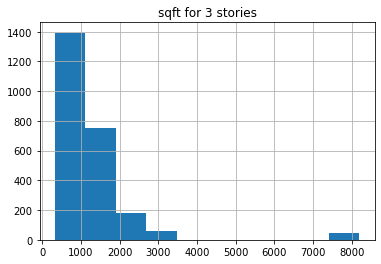

In [294]:
import matplotlib.pyplot as plt
res[res['build_existing_model.geometry_stories']=='3']['sqft'].hist()
plt.title('sqft for 3 stories')

### Get results by building prototypes from Elevate Energy
#### Note: cannot add prototype tags to ResStock results as prototypes overlap in chars

In [330]:
## Elevate Energy prototype chars
groups = pd.read_csv(os.path.join(result_path,'Groups.csv'))
print('prototypes loaded')


prototypes loaded


In [335]:
def get_res_by_prototype(res, row):
    res = res[res['completed_status']=="Success"]
    res_group_i = res[res['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        res['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        res['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        res['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    
    return res_group_i

Metric_map1 = {'count': 'completed_status',
           'median gas': 'simulation_output_report.total_site_natural_gas_therm',
           'median elec': 'simulation_output_report.total_site_electricity_kwh'}
Metric_map2 = {'mean gas': 'simulation_output_report.total_site_natural_gas_therm',
           'mean elec': 'simulation_output_report.total_site_electricity_kwh'} # metric: res_var

## initialize
for metric in {**Metric_map1, **Metric_map2}:
    groups[metric] = np.NAN

### (1) get median consumption
for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res2, row) # <----
    
    for metric, res_var in Metric_map1.items():
        if metric == 'count':
            groups.iloc[i, groups.columns.get_loc('count')] = \
                len(res_group_i[res_group_i['completed_status']=="Success"])
        else:
            groups.iloc[i, groups.columns.get_loc(metric)] = \
                res_group_i[res_var].median()

groups['Gas Diff-med(%)'] = ((groups['Non-normalized gas usage'] - groups['median gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-med(%)'] = ((groups['Non-normalized elec. usage'] - groups['median elec']) / groups['Non-normalized elec. usage']) * 100
print('>> median consumption computed')

### (2) get mean consumption
for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res2, row) # <----
    
    for metric, res_var in Metric_map2.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].mean()

groups['Gas Diff-mean(%)'] = ((groups['Non-normalized gas usage'] - groups['mean gas']) / groups['Non-normalized gas usage']) * 100
groups['Elec Diff-mean(%)'] = ((groups['Non-normalized elec. usage'] - groups['mean elec']) / groups['Non-normalized elec. usage']) * 100
print('>> mean consumption computed')


>> median consumption computed
>> mean consumption computed


In [337]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

## initialize
for metric in {**Metric_map1, **Metric_map2}:
    groups[metric] = np.NAN


for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res2, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].mean()

print('>> median & mean sqft & eui computed:'); print(f'for {vintage}:')

#groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
#                                                         'median gas','mean gas',
#                                                         'median gas eui', 'mean gas eui', 
#                                                         'median elec','mean elec', 
#                                                         'median elec eui','mean elec eui']]

if vintage[0] in ['<1940']:
    query_group = [6, 14, 7, 15]
elif vintage[0] in ['1940s','1950s','1960s','1970s']:
    query_group = [4, 11, 5, 13]
else:
    query_group = [1, 8, 3, 10]

groups.set_index(['HousingGroupNo'])[['HousingGroupName',
                                      'mean gas', 'mean gas eui', 'mean sqft']].loc[query_group]



>> median & mean sqft & eui computed:
for ['1980s', '1990s', '2000s', '2010s']:


,HousingGroupName,mean gas,mean gas eui,mean sqft
HousingGroupNo,,,,
1,Masonry Post-1978 less than 2 stories,893.232987,0.447775,2356.533716
8,Frame Post-1978 Less than 2 stories,909.545470,0.487504,2246.220641
3,Masonry Post-1978 2 or more stories,1354.705805,0.410504,4000.283810
10,Frame Post-1978 2 or more stories,1450.160509,0.465924,3699.487535


In [164]:
### (3) get median & mean sqft & eui
Metric_map1 = {'median sqft': 'sqft',
               'median gas eui': 'gas_eui', 
               'median elec eui': 'elec_eui'}
Metric_map2 = {'mean sqft': 'sqft', 
               'mean gas eui': 'gas_eui', 
               'mean elec eui': 'elec_eui'}

## initialize
for metric in {**Metric_map1, **Metric_map2}:
    groups[metric] = np.NAN


for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res2, row) # <----
    
    ### (3.1) get median values
    for metric, res_var in Metric_map1.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].median()

    ### (3.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].mean()

print('>> median & mean sqft & eui computed:'); print(f'for {vintage}:')

groups.set_index(['HousingGroupNo','HousingGroupName'])[['median sqft', 'mean sqft',
                                                         'median gas','mean gas',
                                                         'median gas eui', 'mean gas eui', 
                                                         'median elec','mean elec', 
                                                         'median elec eui','mean elec eui']]

>> median & mean sqft & eui computed:
for ['2000s']:


,,median sqft,mean sqft,median gas,mean gas,median gas eui,mean gas eui,median elec,mean elec,median elec eui,mean elec eui
HousingGroupNo,HousingGroupName,,,,,,,,,,
1,Masonry Post-1978 less than 2 stories,2176.0,2783.568075,662.383338,800.747613,0.312326,0.368342,8929.921520,10304.484231,3.904222,4.859313
2,Masonry All Years Split Level,2663.0,3573.011655,883.922929,1031.056738,0.320624,0.355498,10052.960721,12362.308686,3.546154,4.356955
3,Masonry Post-1978 2 or more stories,3301.0,4351.490741,1105.983975,1258.167125,0.323061,0.342833,11759.536149,14391.552246,3.247697,3.861574
4,Masonry 1942-1978 Less than 2 Stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Masonry 1942-1978 2 or more stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Masonry Pre-1942 less than 2 stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Masonry Pre-1942 2 or more stories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Frame Post-1978 Less than 2 stories,2176.0,2550.178571,766.604939,829.337051,0.374676,0.415581,8840.154313,10890.316820,4.249133,5.318390
9,Frame Post-1978 Split Level,2663.0,3597.288889,1041.417938,1202.840019,0.376675,0.399748,10037.846304,12468.782812,3.564338,4.294541


In [ ]:
##### (4) get heating and cooling end uses to "groups"
Metric_map1 = ['frac_gas_heating', 'frac_elec_heating', 'frac_elec_cooling']
Metric_map2 = {'size_heating_kbut_h': 'simulation_output_report.size_heating_system_kbtu_h',
               'size_cooling_kbut_h': 'simulation_output_report.size_cooling_system_kbtu_h'}

## initialize
for metric in Metric_map1 + list(Metric_map2.keys()):
    groups[metric] = np.NAN

for i, row in groups.iterrows():
    res_group_i = get_res_by_prototype(res, row)
    
    ### (4.1) get fractions
    groups.iloc[i, groups.columns.get_loc('frac_gas_heating')] = \
        res_group_i['total_gas_heating'].mean()/res_group_i['simulation_output_report.total_site_natural_gas_therm'].mean()

    groups.iloc[i, groups.columns.get_loc('frac_elec_heating')] = \
        res_group_i['total_elec_heating'].mean()/res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    groups.iloc[i, groups.columns.get_loc('frac_elec_cooling')] = \
        res_group_i['total_elec_cooling'].mean()/res_group_i['simulation_output_report.total_site_electricity_kwh'].mean()
    
    ### (4.2) get mean values
    for metric, res_var in Metric_map2.items():
        groups.iloc[i, groups.columns.get_loc(metric)] = \
            res_group_i[res_var].mean()

print('computed')

In [52]:
### (5) get heating & cooling and floor area char breakdowns

House = []
House_chars = [cooling_col, heating_col,
              #'build_existing_model.geometry_floor_area',
              'build_existing_model.insulation_unfinished_attic']

for i, row in groups.iterrows():
    
    res_group_i = get_res_by_prototype(res, row)
    
    Ns = len(res_group_i.query('completed_status=="Success"'))
    Hi = []
    for char in House_chars:
        Nchar = res_group_i.groupby(char)['building_id'].count()/Ns # fractions
        Nchar = Nchar.rename('fraction').to_frame()
        Nchar['housing_char'] = Nchar.index.name
        Hi.append(Nchar)
    
    Hi = pd.concat(Hi, axis=0)
    Hi.index.name = 'sub_char'
    Hi = Hi.reset_index()
    Hi['HousingGroupNo'] = row['HousingGroupNo']
    
    House.append(Hi)
    
House = pd.concat(House, axis=0)
House = pd.pivot_table(House, values='fraction', index=['HousingGroupNo'],
                    columns=['housing_char','sub_char'], aggfunc=np.sum)

print('computed')

computed


In [53]:
## Combine "groups" + "House" into "Out" for export
out = groups.drop(['Stories','WallType','Vintage'], axis=1)
out = pd.concat([out.set_index('HousingGroupNo')], axis=1, keys=['none']).join(House)
out

none  \
                                     HousingGroupName   
HousingGroupNo                                          
1               Masonry Post-1978 less than 2 stories   
2                       Masonry All Years Split Level   
3                 Masonry Post-1978 2 or more stories   
4               Masonry 1942-1978 Less than 2 Stories   
5                 Masonry 1942-1978 2 or more stories   
6                Masonry Pre-1942 less than 2 stories   
7                  Masonry Pre-1942 2 or more stories   
8                 Frame Post-1978 Less than 2 stories   
9                         Frame Post-1978 Split Level   
10                  Frame Post-1978 2 or more stories   
11                Frame 1942-1978 less than 2 stories   
12                         Frame Pre-1942 Split Level   
13                  Frame 1942-1978 2 or more stories   
14                 Frame Pre-1942 less than 2 stories   
15                   Frame Pre-1942 2 or more stories   

                                                                            \
               Non-normalized gas usage Non-normalized elec. usage   count   
HousingGroupNo                                                               
1                                  1133                      10282   697.0   
2                                  1416                       9661  8897.0   
3                                  1812                      18225   525.0   
4                                  1210                       8779  4826.0   
5                                  1427                      10549  1182.0   
6                                  1504                       9299   732.0   
7                                  2044                      13272   935.0   
8                                  1054                       9353   562.0   
9                                  1168                      10445  1284.0   
10                                 1422                      13495   722.0   
11                                 1176                       9213  2820.0   
12                                 1297                       9964  2102.0   
13                                 1530                      12543  1504.0   
14                                 1340                       9103   698.0   
15                                 1753                      11967  1404.0   

                                                                      \
                 median gas   median elec     mean gas     mean elec   
HousingGroupNo                                                         
1                827.585075   8833.301226   893.232987   9960.114058   
2               1184.916074   9266.321551  1308.704726  10773.268192   
3               1186.896059  11504.558180  1354.705805  13962.779918   
4               1066.568715   8673.199620  1144.934814   9750.833165   
5               1585.913502  10468.396412  1740.809866  12129.312601   
6               1243.747079   9165.958694  1326.414207  10406.407874   
7               1727.143977  11221.616930  1877.769129  13438.769240   
8                857.235591   8833.450771   909.545470  10121.030958   
9               1081.240703   9922.163042  1213.536170  11898.767307   
10              1250.522248  10769.909253  1450.160509  13282.545462   
11              1138.183147   8783.392501  1202.352338   9772.250161   
12              1547.068005  10397.400468  1652.098364  11851.278133   
13              1589.492116  10525.777462  1765.290380  11955.967475   
14              1262.042987   8757.546055  1335.188968   9886.813252   
15              1694.297166  11104.625516  1809.650186  12827.913807   

                                                 ...  \
               Gas Diff-med(%) Elec Diff-med(%)  ...   
HousingGroupNo                                   ...   
1                    26.956304        14.089659  ...   
2                    16.319486         4.085275  ...   
3                    34.498010        36

### Write output to folder

In [54]:
#out_name = "Groups_results" + "_" + baseline_result.split("_")[2]
out.to_csv(os.path.join(result_path, iteration_path, 'baseline_prototype_results.csv'), index=True)
print(f'file saved to:\n  {os.path.join(result_path, iteration_path)}')

file saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_2007_10/baseline
